# State Estimation with Kalman Filters

State estimation is essential in various engineering and scientific domains where precise knowledge of a system's full-state, state---such as its position, velocity, and acceleration---is essential but directly unobservable due to limitations in measurement availability and accuracy. For instance, in autonomous vehicle navigation, accurately estimating the vehicle's position, orientation, and velocity in real-time is vital to ensure safety and operational efficiency, but direct measurements for the full state may not be available. State estimation helps to fill the gaps left by imperfect sensors and an incomplete set of measurements by providing a statistically optimal estimate based on models of the system dynamics and measurement processes. This approach is key in managing the inherent uncertainties and noise in measurements, allowing for more reliable and accurate system control and decision-making.


The Kalman Filter and its variants form a family of algorithms underpinned by the principles of predictive correction, optimality (for linear systems), and recursion. The filters operates in two main phases: prediction and update. In the prediction phase, they use the system's previous state and control inputs to produce an estimate of the current state. In the update phase, they incorporate the new measurement data to refine this estimate. The beauty of the Kalman Filter lies in its recursive nature, allowing it to run in real-time and be computationally efficient, making it ideal for many practical applications. Extensions of the Kalman Filter, like the Extended and Unscented Kalman Filters, adapt these principles to handle non-linear systems by using different linearization techniques or sampling methods.

In this tutorial we demonstrate how the Kalman Filter and its variants can be easily constructed in Collimator. For a continuous-time Pendulum plant, we demonstrate the convenience of creating such filters by passing the entire plant to the convenience functions available in Collimator, while the linearization and discretization of the plant is automatically handled by Collimator.

## Pendulum plant

The Pendulum plant is well described in our previous tutorial on [Linear Quadratic Regulator (LQR)](https://py.collimator.ai/examples/lqr/#stabilizing-a-pendulum-at-the-up-swing-position), which also shows how to linearize the continuous-time plant. We recap the dynamics here. Consider a pendulum with a rigid rod of length $ L $ and a point mass $ m $ at the end (see schematic shown below). The pendulum is actuated by a torque $ u $ applied at the pivot. The damping coefficient is $b$.

<img src="../media/pendulum.png" alt="pendulum" style="width: 300px;"/>

The dynamics of this pendulum are given by the following with $ \omega = \dot{\theta} $ as the angular velocity and state $\mathbf{x} = [\theta \quad \omega]^\text{T}$:

\begin{equation}
\dot{\mathbf{x}} = 
\begin{bmatrix}
\dot{\theta} \\ \dot{\omega}
\end{bmatrix} =  
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \omega +  \dfrac{u}{m L^2}
\end{bmatrix}. \tag{1}
\end{equation}

We also assume that only the angular position $\theta$ is available as the measurement $\mathbf{y}$:

$$\mathbf{y} = \theta.$$

Note that for the LQR tutorial, it was assumed that the full state $\mathbf{x}$ of the Pendulum, i.e. both its angular position $\theta$ and angular velocity $\omega$ were available to the LQR. However, in the above setup for the Pendulum, only $\theta$ is measured. This is where Kalman Filter plays a critical role---with noisy measurements of a part (or a transformation) of the state $\mathbf{y}$, it provides optimal estimates for the full state $\mathbf{x}$, which in-turn may be used by any control strategy that requires full state, for example the LQR, Model Predictive Control, etc.

# Linear Filters

## Kalman Filter recursion

Consider the following linear discrete-time system with state vector $\mathbf{x}[k]$, measurement vector $\mathbf{y}[k]$, and control vector $\mathbf{u}[k]$ :
\begin{align}
\mathbf{x}[k+1] &= \mathbf{A}_d \mathbf{x}[k] + \mathbf{B}_d \mathbf{u}[k] + \mathbf{G}_d \mathbf{w}[k],\\[5pt]
\mathbf{y}[k] &= \mathbf{C}_d \mathbf{x}[k] + \mathbf{D}_d \mathbf{u}[k] +\mathbf{v}[k], \tag{2}
\end{align}

with

\begin{align}
\mathbf{w}[k] &\sim \mathcal{N}(\mathbf{0}, \mathbf{Q_d}),\\[5pt]
\mathbf{v}[k] &\sim \mathcal{N}(\mathbf{0}, \mathbf{R_d}),\\
\end{align}

where, 
\begin{align}
\mathbf{A}_d & \quad \text{: State transition matrix}\\[5pt]
\mathbf{B}_d & \quad \text{: Input matrix}\\[5pt]
\mathbf{C}_d & \quad \text{: Output matrix}\\[5pt]
\mathbf{D}_d & \quad \text{: Feedthrough matrix}\\[5pt]
\mathbf{G}_d & \quad \text{: Process noise matrix}\\[5pt]
\mathbf{Q}_d & \quad \text{: Process noise covariance matrix}\\[5pt]
\mathbf{R} & \quad \text{: Measurement noise covariance matrix}\\[5pt]
\mathbf{w}[k] & \quad \text{: Process noise }\\[5pt]
\mathbf{v}[k] & \quad \text{: Measurement noise}.\\[5pt]
\end{align}


For the above system, the Kalman Filter recursion equations are as follows:

1. **Prediction/Propagation step**:
\begin{align}
\mathbf{\hat{x}}_{k|k-1} &= \mathbf{A}_d \mathbf{\hat{x}}_{k-1|k-1} + \mathbf{B}_d \mathbf{u}[k-1] &\quad \text{(a) Predicted (a priori) state estimate} \\[5pt]
\mathbf{P}_{k|k-1} &= \mathbf{A}_d \mathbf{P}_{k-1|k-1} \mathbf{A}_d^T + \mathbf{G}_d \mathbf{Q}_d \mathbf{G}_d^T &\quad \text{(b) Predicted (a priori) estimate covariance}
\end{align}

2. **Update/Correction step**:
\begin{align}
\mathbf{K}_k &= \mathbf{P}_{k|k-1} \mathbf{C}_d^T (\mathbf{C}_d \mathbf{P}_{k|k-1} \mathbf{C}_d^T + \mathbf{R}_d)^{-1} &\quad \text{(c) Kalman gain} \\[5pt]
\mathbf{\hat{x}}_{k|k} &= \mathbf{\hat{x}}_{k|k-1} + \mathbf{K}_k (\mathbf{y}[k] - \mathbf{C}_d \mathbf{\hat{x}}_{k|k-1} - \mathbf{D}_d \mathbf{u}[k]) &\quad \text{(d) Updated (a posteriori) state estimate} \\[5pt]
\mathbf{P}_{k|k} &= (\mathbf{I} - \mathbf{K}_k \mathbf{C}_d) \mathbf{P}_{k|k-1} &\quad \text{(e) Updated (a posteriori) estimate covariance}
\end{align}

where:

- $\mathbf{\hat{x}}_{k|k-1}$ is the state estimate at time $k$ given measurements up to time $k-1$.
  
- $\mathbf{\hat{x}}_{k|k}$ is the state estimate at time $k$ given measurements up to time $k$.

- $\mathbf{P}_{k|k-1}$ is the state estimate covariance at time $k$ given measurements up to time $k-1$.
  
- $\mathbf{P}_{k|k}$ is the state estimate covariance at time $k$ given measurements up to time $k$.

- $\mathbf{K}_k$ is the Kalman gain at time $k$.

Through the above states, starring from an initial state estimate $\mathbf{\hat{x}}_0 = \mathbf{\hat{x}}_{0|0}$ and $\mathbf{\hat{P}}_0 = \mathbf{P}_{0|0}$, the Kalman Filter recursively generates optimal estimates for the state.

### Linearization and discretization

Note that the above recursion for the Kalman Filter works on a discrete-time linear representation of the plant, eq (2). In our case, the Pendulum plant of eq (1) is continuous-time. Furthermore, it is also nonlinear. For the former, any discretization strategy such as Euler, Zero-order hold, Runge-Kutta methods, etc. may be utilized. For the latter, a linearized version of the continuous plant can be obtained at equilibrium points. This aspect has been covered in the previous [LQR](https://py.collimator.ai/examples/lqr/#stabilizing-a-pendulum-at-the-up-swing-position) tutorial. For Kalman Filters, Collimator provides convenience utility method to directly take the continuous-time plant as an input, and automatically perform its linearization and discretization. Let's see this in action below.

We begin by importing the relevant libraries to create the plant, along with the Kalman Filter and its variants.

In [1]:
from math import ceil
import matplotlib.pyplot as plt
import jax.numpy as jnp

import collimator

from collimator.framework import LeafSystem
from collimator.simulation import SimulatorOptions

from collimator.library import (
    # primitive blocks to construct plant
    Constant,
    Adder,
    IOPort,
    ZeroOrderHold,
    # blocks to contruct noise and disturbance
    WhiteNoise,
    DotProduct,
    # Kalman Filter and its variants
    KalmanFilter,
    InfiniteHorizonKalmanFilter,
    ContinuousTimeInfiniteHorizonKalmanFilter,
    ExtendedKalmanFilter,
    UnscentedKalmanFilter
)

%load_ext autoreload
%autoreload 2

### Pendulum plant

We create a LeafSystem implementing the Pendulum plant, eq (1), ensuring that its output is only the partial state measurement of $\theta$. You may build this plant with primitive blocks as well (see for example, [this tutorial](https://py.collimator.ai/examples/primitives/)).

In [2]:
class Pendulum(LeafSystem):
    """
    A simple pendulum model with damping. State is [theta, omega], and output is
    the partial state measurement of [theta].
    """

    def __init__(self, *args, x0=jnp.zeros(2), m=1.0, L=1.0, d=0.2, g=9.81, **kwargs):
        super().__init__(*args, **kwargs)
        self.declare_dynamic_parameter("m", m)
        self.declare_dynamic_parameter("L", L)
        self.declare_dynamic_parameter("d", d)
        self.declare_dynamic_parameter("g", g)

        self.declare_input_port(name="tau")

        self.declare_continuous_state(shape=(2,), ode=self.ode, default_value=x0)

        self.declare_output_port(self._eval_output)

    def _eval_output(self, time, state, *inputs, **parameters):
        theta, omega = state.continuous_state
        return theta

    def ode(self, time, state, *inputs, **parameters):
        (u,) = inputs
        theta, omega = state.continuous_state

        m = parameters["m"]
        L = parameters["L"]
        d = parameters["d"]
        g = parameters["g"]
        mL2 = m * L**2

        dot_theta = omega
        dot_omega = u / mL2 - d * omega / mL2 - g * jnp.sin(theta) / L

        return jnp.array([dot_theta, dot_omega[0]])

### Pendulum model with disurbances

Next, we create the Pendulum plant with disturbances. We introduce process noise in the above continuous plant by making the control torque input $u$ noisy by adding a zero-mean white noise of covariance $\mathbf{Q}$ to it. We also introduce measurement noise by making adding a zero-mean white noise of covariance $\mathbf{R}$ to the output of the above plant. Collimator provides a `WhiteNoise` block, which can generate continuous-time noise with Identity covariance matrix. To obtain noise with any given covariance $\mathbf{N}$, we can pre-multiply the output of the `WhiteNoise` block by the Cholesky factorization of $\mathbf{N}$. This subdiagram is abstracted in the `make_disturbance_from_noise_covariance` function below.

In [3]:
def make_disturbance_from_noise_covariance(covariance, name=None):
    n = covariance.shape[0]
    chol_cov = jnp.linalg.cholesky(covariance)
    builder = collimator.DiagramBuilder()
    fs = 100.0
    unit_noise = builder.add(WhiteNoise(correlation_time=1.0/fs, noise_power=1.0, shape=(n,), seed=42, name="unit_noise"))
    chol_noise = builder.add(Constant(chol_cov, name="chol_cov"))
    noise = builder.add(DotProduct(name="noise"))
    builder.connect(chol_noise.output_ports[0], noise.input_ports[0])
    builder.connect(unit_noise.output_ports[0], noise.input_ports[1])
    builder.export_output(noise.output_ports[0])
    diagram = builder.build(name=name)
    return diagram

Subsquently, we modify the noiseless Pendulum plant we created previously by adding the process and measurement noises. This is implemented in the function below.

In [4]:
def make_pendulum_with_disturbances(
    x0,
    Q,
    R,
    config=None,
):
    """
    Returns a diagram with a pendulum and disturbances.
    Process noise with covariance Q is added to the input torque of the pendulum.
    Measurement noise R is added to the angle theta of the pendulum to generate
    the measurement.
    """
    builder = collimator.DiagramBuilder()
    if config is None:
        pendulum = builder.add(Pendulum(x0=x0, name="pendulum"))
    else:
        pendulum = builder.add(Pendulum(x0=x0, **config, name="pendulum"))

    process_noise = builder.add(
        make_disturbance_from_noise_covariance(covariance=Q, name="process_noise")
    )
    measurement_noise = builder.add(
        make_disturbance_from_noise_covariance(covariance=R, name="measurement_noise")
    )
    
    noisy_torque = builder.add(Adder(2, name="noisy_torque"))
    input_torque = builder.add(IOPort(name="input_torque"))
    theta_measured = builder.add(Adder(2, name="theta_measured"))

    builder.connect(noisy_torque.output_ports[0], pendulum.input_ports[0])

    builder.connect(process_noise.output_ports[0], noisy_torque.input_ports[0])
    builder.connect(input_torque.output_ports[0], noisy_torque.input_ports[1])

    builder.connect(measurement_noise.output_ports[0], theta_measured.input_ports[0])
    builder.connect(pendulum.output_ports[0], theta_measured.input_ports[1])

    builder.export_input(input_torque.input_ports[0])
    builder.export_output(theta_measured.output_ports[0])

    diagram = builder.build(name="pendulum_with_disturbances")
    return diagram

The above function will create a continuous Pendulum plant with noise/disturbances. However, it is non-linear. For Kalman Filter, we need a linear plant, which can be obtained by linearization of the Pendlum around its equilibrium (fixed) point $[\bar{\mathbf{x}}, \bar{\mathbf{u}}]$. While the Collimator utility will automatically perform linearization, the resulting Kalman Filter will be in the coordinates relative to the equilibrium points. To address this, we create the following `make_estimator_diagram`, which can perform the transformation back to the global coordinates. In the examples presented below, this is not strictly necessary as the equilibrium point considered is $[\bar{\mathbf{x}}=\mathbf{0}, \bar{\mathbf{u}}=\mathbf{0}]$ and the plant output is also $\mathbf{0}$. Thus the transformations are identity. However, the mechanism is included here for generality.

In [5]:
def make_estimator_diagram(kf, x_eq, u_eq, y_eq, name=None):
    """
    Make a Diagram for a Kalman Filter that has been obtained for a nonlinear plant
    linearized at equilibrium point (x_eq, u_eq, y_eq).

    The system:
    (i) Takes the control vector `u` and measurement vector `y` as inputs.
    (ii) transforms `u` and `y` to `u_bar` and `y_bar`, respectively,
         where the variables `u_bar` and `y_bar` are
            u_bar = u - u_eq,
            y_bar = y - y_eq.
    (iii) Applies the Kalman Filter `kf` to the transformed variables `u_bar` and
    `y_bar`, obtaining the state estimate `x_hat_bar`.
    (iv) Transforms `x_hat_bar` to `x_hat` and outputs this estimate:
        x_hat = x_hat_bar + x_eq.

    Parameters:
    kf : a `KalmanFilter` object.
        The Kalman filter to be used.
    x_eq : jnp.ndarray
        The equilibrium point for the plant's state.
    u_eq : jnp.ndarray
        The equilibrium point for the plant's input.
    y_eq : jnp.ndarray
        The plant's output at equilibrium point.

    Returns:
    diagram : a `Diagram` object.
        The Diagram for the Kalman filter with:

        Input ports:
            (0) u: control vector
            (1) y: measurement vector

        Output ports:
            (0) x_hat: State vector estimate

        Parameters:
            None
    """
    builder = collimator.DiagramBuilder()

    builder.add(kf)

    u = builder.add(IOPort(name="u"))
    y = builder.add(IOPort(name="y"))

    u_eq = builder.add(Constant(u_eq, name="u_eq"))
    y_eq = builder.add(Constant(y_eq, name="y_eq"))

    u_bar = builder.add(Adder(2, operators="+-", name="u_bar"))
    y_bar = builder.add(Adder(2, operators="+-", name="y_bar"))

    builder.connect(u.output_ports[0], u_bar.input_ports[0])
    builder.connect(u_eq.output_ports[0], u_bar.input_ports[1])

    builder.connect(y.output_ports[0], y_bar.input_ports[0])
    builder.connect(y_eq.output_ports[0], y_bar.input_ports[1])

    builder.connect(u_bar.output_ports[0], kf.input_ports[0])
    builder.connect(y_bar.output_ports[0], kf.input_ports[1])

    x_eq = builder.add(Constant(x_eq, name="x_eq"))
    x_hat = builder.add(Adder(2, operators="++", name="x_hat"))

    builder.connect(x_eq.output_ports[0], x_hat.input_ports[0])
    builder.connect(kf.output_ports[0], x_hat.input_ports[1])

    builder.export_input(u.input_ports[0])
    builder.export_input(y.input_ports[0])

    builder.export_output(x_hat.input_ports[0])

    diagram = builder.build(name=name)

    return diagram

With the above utilities, we are now ready to create the Kalman Filter. Let's create the configuration first. We need to specify the continuous-time process and noise matrices $\mathbf{Q}$ and $\mathbf{R}$, and the equilirium point (down orientation of the Pendulum) for the automatic linearization of the plant. We also need to specify the initial state and covariance matrices for the Kalman Filter state estimates.

### Configuration

In [6]:
nx = 2 # state size
nu = 1 # control size
ny = 1 # measurement size

Q = 1.0e-01 * jnp.eye(nu)  # process noise
R = 1.0e-02 * jnp.eye(ny)  # measurement noise

u_eq = jnp.array([0.0]) # Equilibrium control for the down configuration
x_eq = jnp.array([0.0, 0.0]) # Equilibrium state for the down configuration

x0 = jnp.array([jnp.pi / 20, 0.0]) # Initial state
x_hat_bar_0 = jnp.array([jnp.pi / 15.0, 0.1]) # Initial state estimate relative to equilibrium
P_hat_bar_0 = 0.01 * jnp.eye(nx) # Initial covariance estimate of state relative to equilibrium

dt = 0.01 # time-step for discretization

Tsim = 10.0 # total simulation time
nseg = ceil(Tsim / dt) # number of discrete-time segments

We can now construct the Kalman Filter through the `KalmanFilter.for_continuous_plant` utility, to which we can pass the continuous-time plant. For other ways to use the `KalmanFilter`, please see documentation.

In [7]:
y_eq, kf_bar = KalmanFilter.for_continuous_plant(
        Pendulum(x0=x0, name="pendulum"), # continuous plant
        x_eq,
        u_eq,
        dt,
        Q,
        R,
        G=None,
        x_hat_bar_0=x_hat_bar_0,
        P_hat_bar_0=P_hat_bar_0,
        discretization_method="zoh", # "zoh" or "euler"
        discretized_noise=False,
    )

The above call linearizes the continuous plant at the provided equilibrium points `(x_eq, u_eq)`, and returns `y_eq` (plant output at equilibrium point) and the Kalman Filter `kf_bar` for the linearized and discretized plant. The `kf_bar` filter is in the coordinates relative the equilibrium points. We can use the `make_estimator_diagram` utility to transform `kf_bar` into global coordinates, and wire it up with the noisy plant. 

A schematic of the diagram we are building in code is shown below

<img src="../media/kf_for_ct_plant.png" alt="KF Collimator Diagram" style="width: 600px;"/>

In [8]:
builder = collimator.DiagramBuilder()

pendulum = builder.add(make_pendulum_with_disturbances(x0, Q, R)) # plant with disturbances

kf = builder.add(make_estimator_diagram(kf_bar, x_eq, u_eq, y_eq, name="kf"))

control = builder.add(Constant(jnp.array([0.0]), name="control")) # zero deterministic control

builder.connect(control.output_ports[0], kf.input_ports[0])
builder.connect(pendulum.output_ports[0], kf.input_ports[1])
builder.connect(control.output_ports[0], pendulum.input_ports[0])

diagram = builder.build()

Next, we can simulate the system and plot the results.

In [9]:
context = diagram.create_context()

recorded_signals = {
    "x_true": diagram["pendulum_with_disturbances"]["pendulum"].output_ports[0],
    "x_hat": kf.output_ports[0],
    "theta_measured": pendulum.output_ports[0],
}

options = SimulatorOptions(
    rtol = 1e-06,
    atol = 1e-08,
    max_major_steps=10 * nseg,
    max_major_step_length=dt,
)

sol = collimator.simulate(
    diagram,
    context,
    (0.0, Tsim),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.01, max_major_steps=10000, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 3 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


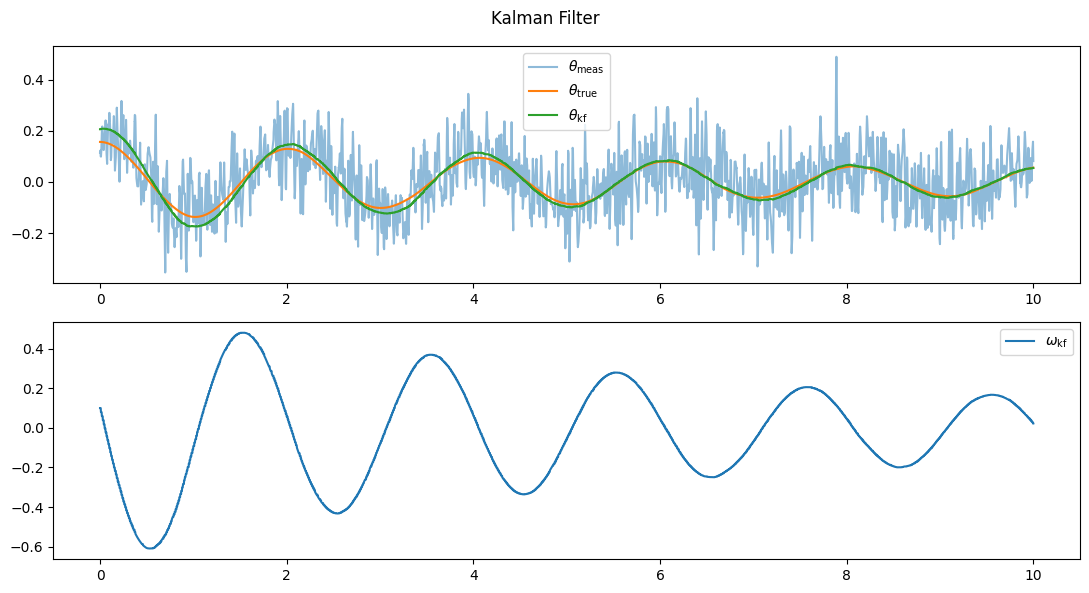

In [10]:
def plot_sol(sol, title="Kalman Filter"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
    ax1.plot(
        sol.time,
        sol.outputs["theta_measured"],
        label=r"$\theta_\mathrm{meas}$",
        alpha=0.5,
    )
    ax1.plot(sol.time, sol.outputs["x_true"], label=r"$\theta_\mathrm{true}$")
    ax1.plot(sol.time, sol.outputs["x_hat"][:, 0], label=r"$\theta_\mathrm{kf}$")
    ax2.plot(sol.time, sol.outputs["x_hat"][:, 1], label=r"$\omega_\mathrm{kf}$")

    ax1.legend()
    ax2.legend()
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

plot_sol(sol, "Kalman Filter")

We notice that despite the large noise in the measurement of $\theta$, the Kalman Filter provides a good estimate of both $\theta$ and $\omega$.

## Infinite horizon Kalman Filter (discrete-time)

The Infinite Horizon Kalman Filter (IHKF), also known as the Steady-State Kalman Filter, is an adaptation of the traditional Kalman Filter presented above, where the filter gains converge to constant values as time progresses to infinity. This filter is particularly useful in systems where the dynamics, noise characteristics, and observation models are constant over time.

### Steady-State Equations:

For the same system as eq (1), once the system reaches a steady state, the recursion equations stabilize to constant values:

1. **Steady-State Kalman Gain**:
\begin{align}
\mathbf{K}_\infty &= \mathbf{P}_\infty \mathbf{C}_d^T (\mathbf{C}_d \mathbf{P}_\infty \mathbf{C}_d^T + \mathbf{R}_d)^{-1} &\quad \text{(a) Steady-State Kalman gain}
\end{align}

2. **Steady-State Error Covariance**:
\begin{align}
\mathbf{P}_\infty &= \mathbf{A}_d \mathbf{P}_\infty \mathbf{A}_d^T - \mathbf{A}_d \mathbf{P}_\infty \mathbf{C}_d^T (\mathbf{C}_d \mathbf{P}_\infty \mathbf{C}_d^T + \mathbf{R}_d)^{-1} \mathbf{C}_d \mathbf{P}_\infty \mathbf{A}_d^T + \mathbf{G}_d \mathbf{Q}_d \mathbf{G}_d^T &\quad \text{(b) Steady-State error covariance}
\end{align}

These steady-state values are derived by solving the above Discrete-Time Algebraic Riccati Equation (DARE), ensuring that the filter no longer relies on iterative updates for $\mathbf{P}_k$ and $\mathbf{K}_k$. This yields computational efficiency and consistent performance in long-running systems.

With $\mathbf{K}_\infty$ and $\mathbf{P}_\infty$, the Infinite Horizon Kalman Filter provides a robust approach for systems operating under steady conditions, simplifying implementation and reducing computation in environments where rapid recalculations are impractical or unnecessary. The Collimator `InfiniteHorizonKalmanFilter.for_continuous_plant` utility can automatically compute the steady state gain and covariances.

The implementation of IHKF is similar to that presented above for the traditional Kalman Filter. We instantiate the filter with the `InfiniteHorizonKalmanFilter.for_continuous_plant` utility in an identical manner, except that we do not need to provide the initial value for the covariance matrix.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.01, max_major_steps=10000, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 3 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


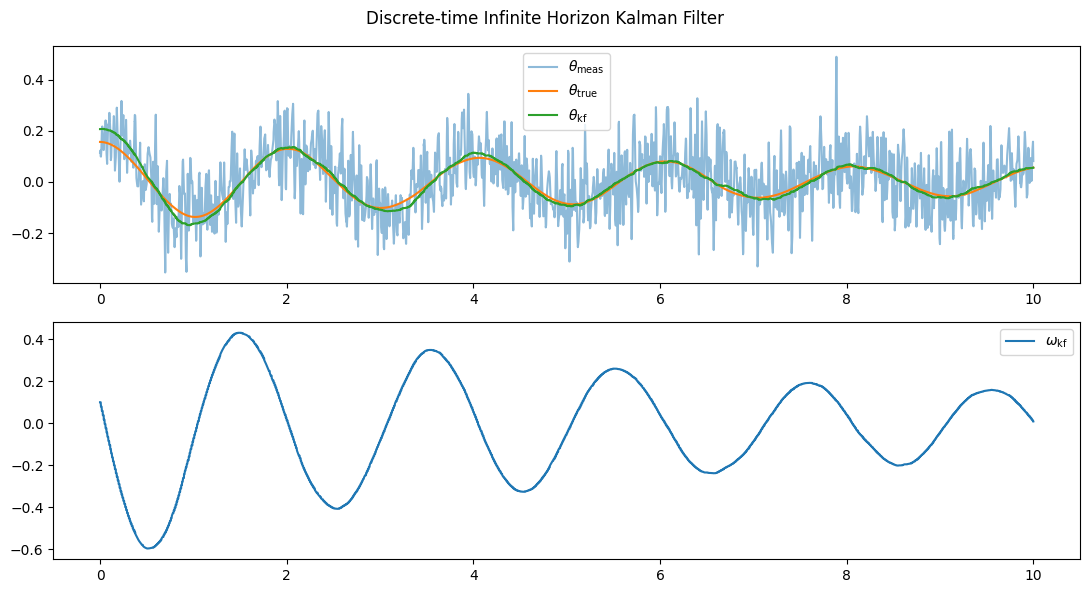

In [11]:
builder = collimator.DiagramBuilder()

pendulum = builder.add(make_pendulum_with_disturbances(x0, Q, R))

y_eq, kf_bar = InfiniteHorizonKalmanFilter.for_continuous_plant(
        Pendulum(x0=x0, name="pendulum"),
        x_eq,
        u_eq,
        dt,
        Q,
        R,
        G=None,  # if None, assumes u = u+w, so G = B
        x_hat_bar_0=x_hat_bar_0,
        discretization_method="zoh",
        discretized_noise=False,
    )

kf = builder.add(make_estimator_diagram(kf_bar, x_eq, u_eq, y_eq, name="kf"))

control = builder.add(Constant(jnp.array([0.0]), name="control"))

builder.connect(control.output_ports[0], kf.input_ports[0])
builder.connect(pendulum.output_ports[0], kf.input_ports[1])
builder.connect(control.output_ports[0], pendulum.input_ports[0])

diagram = builder.build()

context = diagram.create_context()

recorded_signals = {
    "x_true": diagram["pendulum_with_disturbances"]["pendulum"].output_ports[0],
    "x_hat": kf.output_ports[0],
    "theta_measured": pendulum.output_ports[0],
}

sol = collimator.simulate(
    diagram,
    context,
    (0.0, Tsim),
    options=options,
    recorded_signals=recorded_signals,
)

plot_sol(sol, "Discrete-time Infinite Horizon Kalman Filter")

We observe that the IHKF has slightly poorer performance relative to the traditional Kalman Filter. However, it is significantly more computationally efficient.

## Infinite horizon Kalman Filter (continuous-time)

The continuous-time Infinite Horizon Kalman Filter (also known as the Kalman-Bucy filter) is an extension of the Kalman Filter to continuous-time systems where the filter gains converge to constant values as time approaches infinity. Since the filter works with continuous-time systems, plant discretization is not necessary.

Consider, a continuous-time system as follows:

\begin{align}
d\mathbf{x}(t) &= \mathbf{A}_c \mathbf{x}(t) dt + \mathbf{B}_c \mathbf{u}(t) dt + \mathbf{G}_c d\mathbf{w}(t),\\[5pt]
d\mathbf{y}(t) &= \mathbf{C}_c \mathbf{x}(t) dt + \mathbf{D}_c \mathbf{u}(t) dt + d\mathbf{v}(t),
\end{align}

where

\begin{align}
\mathbf{w}(t) &\sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_c dt),\\[5pt]
\mathbf{v}(t) &\sim \mathcal{N}(\mathbf{0}, \mathbf{R}_c dt),\\
\end{align}

and $\mathbf{A}_c, \mathbf{B}_c, \mathbf{C}_c, \mathbf{D}_c, \mathbf{G}_c, \mathbf{Q}_c, \mathbf{R}_c, \mathbf{w}(t), \mathbf{v}(t)$ represent the continuous-time system matrices and noise processes.

### Steady-State Equations:

In the steady state, the filter achieves a fixed structure for the filter gain and error covariance, which are computed as follows:

1. **Steady-State Kalman Gain**:
\begin{align}
\mathbf{K}_\infty &= \mathbf{P}_\infty \mathbf{C}_c^T \mathbf{R}_c^{-1} &\quad \text{(a) Steady-State Kalman gain}
\end{align}

2. **Steady-State Error Covariance**:
\begin{align}
\mathbf{0} &= \mathbf{P}_\infty \mathbf{A}_c^T + \mathbf{A}_c \mathbf{P}_\infty + \mathbf{G}_c \mathbf{Q}_c \mathbf{G}_c^T - \mathbf{P}_\infty \mathbf{C}_c^T \mathbf{R}_c^{-1} \mathbf{C}_c \mathbf{P}_\infty &\quad \text{(b) Steady-State error covariance}
\end{align}

These steady-state values are derived by solving the above Continuous-Time Algebraic Riccati Equation (CARE). This filter offers several advantages, including reduced computational demands and improved stability over long operational periods, as the filter's performance does not degrade with time.

Utilizing $\mathbf{K}_\infty$ and $\mathbf{P}_\infty$, the Infinite Horizon Continuous-Time Kalman Filter ensures consistent and efficient state estimation for systems subjected to continuous inputs and observations. The estimator for the state $\hat{\mathbf{x}}$ becomes an ODE:

$$ \frac{d \hat{\mathbf{x}}}{dt} = \mathbf{(A-K_{\infty}C)} \hat{\mathbf{x}} + \mathbf{(B-K_{\infty}D)u} + \mathbf{K_{\infty}y}$$

The Collimator `ContinuousTimeInfiniteHorizonKalmanFilter.for_continuous_plant` utility can automatically compute the steady state gain and covariances.

Similarly to as we did before for other filters, we instantiate the filter with the `ContinuousTimeInfiniteHorizonKalmanFilter.for_continuous_plant` utility, except that we do not need to provide the the discrete-time interval and discretization parameters.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.01, max_major_steps=10000, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 3 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


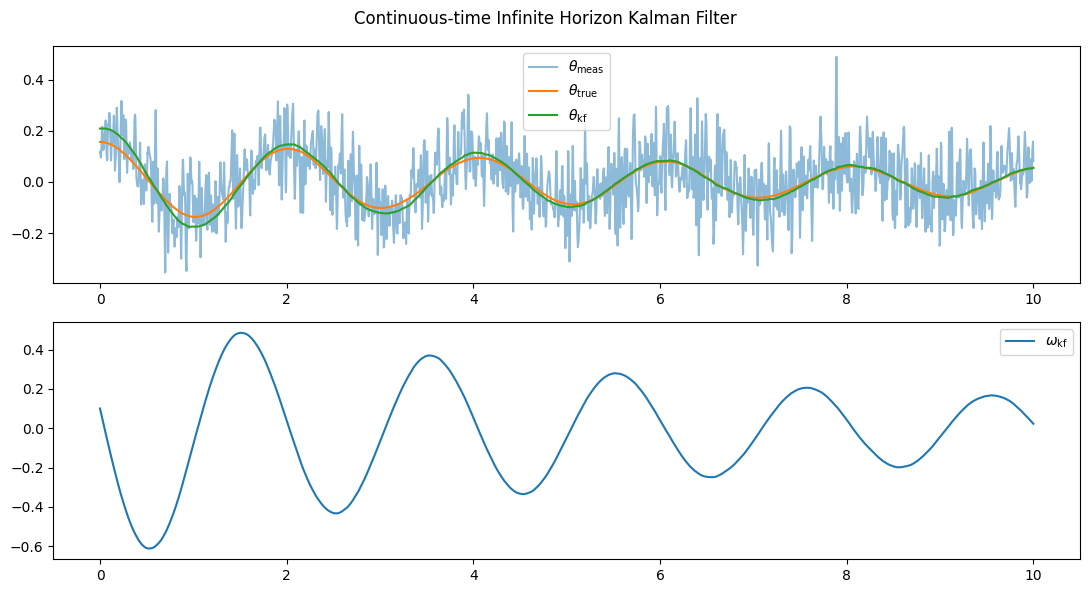

In [12]:
builder = collimator.DiagramBuilder()

pendulum = builder.add(make_pendulum_with_disturbances(x0, Q, R))

y_eq, kf_bar = ContinuousTimeInfiniteHorizonKalmanFilter.for_continuous_plant(
        Pendulum(x0=x0, name="pendulum"),
        x_eq,
        u_eq,
        Q,
        R,
        G=None,  # if None, assumes u = u+w, so G = B
        x_hat_bar_0=x_hat_bar_0,
    )

kf = builder.add(make_estimator_diagram(kf_bar, x_eq, u_eq, y_eq, name="kf"))

control = builder.add(Constant(jnp.array([0.0]), name="control"))

builder.connect(control.output_ports[0], kf.input_ports[0])
builder.connect(pendulum.output_ports[0], kf.input_ports[1])
builder.connect(control.output_ports[0], pendulum.input_ports[0])

diagram = builder.build()

context = diagram.create_context()

recorded_signals = {
    "x_true": diagram["pendulum_with_disturbances"]["pendulum"].output_ports[0],
    "x_hat": kf.output_ports[0],
    "theta_measured": pendulum.output_ports[0],
}


sol = collimator.simulate(
    diagram,
    context,
    (0.0, Tsim),
    options=options,
    recorded_signals=recorded_signals,
)

plot_sol(sol, "Continuous-time Infinite Horizon Kalman Filter")

As before, this filter too provides good estimates of $\theta$ and $\omega$.

So far, we worked with linear variants of the Kalman Filter. Since our plant is nonlinear, we linearized the plant around the 'down' orientation of the Pendulum plant. Consequently, our linearized model is only valid in the region around the equilibrium point, and we were restricted to this region (reflected in our choice of the initial condition not being too far away from the equilibrium point, ensuring that the plant remains in a region where linearization is valid). If we need to perform state estimation in regions far from the equilibrium point, we need to employ nonlinear variants in the Kalman Filter family, which do not require a linear plant. These extensions are presented next.

# Nonlinear extensions

The two primary nonlinear variants of the Kalman Filter are the Extended Kalman Filter (EKF) and the Unscented Kalman Filter (UKF).

## Extended Kalman Filter (EKF)

EKF is used to estimate the state of a nonlinear system, and it linearizes the plant about the current estimate to apply the traditional Kalman Filter equations.

Consider the following nonlinear discrete-time system with state vector $\mathbf{x}[k]$, measurement vector $\mathbf{y}[k]$, and control vector $\mathbf{u}[k]$:
\begin{align}
\mathbf{x}[k+1] &= \mathbf{f}(\mathbf{x}[k], \mathbf{u}[k]) + \mathbf{G}\mathbf{w}[k],\\[5pt]
\mathbf{y}[k] &= \mathbf{h}(\mathbf{x}[k], \mathbf{u}[k]) + \mathbf{v}[k],
\end{align}

with

\begin{align}
\mathbf{w}[k] &\sim \mathcal{N}(\mathbf{0}, \mathbf{Q}),\\[5pt]
\mathbf{v}[k] &\sim \mathcal{N}(\mathbf{0}, \mathbf{R}),\\
\end{align}

where, 
\begin{align}
\mathbf{f} & \quad \text{: State transition function}\\[5pt]
\mathbf{h} & \quad \text{: Measurement function}\\[5pt]
\mathbf{Q} & \quad \text{: Process noise covariance matrix}\\[5pt]
\mathbf{R} & \quad \text{: Measurement noise covariance matrix}\\[5pt]
\mathbf{w}[k] & \quad \text{: Process noise}\\[5pt]
\mathbf{v}[k] & \quad \text{: Measurement noise}.\\[5pt]
\end{align}

For the above system, the Extended Kalman Filter recursion equations are as follows:

1. **Prediction/Propagation step**:
\begin{align}
\mathbf{\hat{x}}_{k|k-1} &= \mathbf{f}(\mathbf{\hat{x}}_{k-1|k-1}, \mathbf{u}[k-1]) &\quad \text{(a) Predicted (a priori) state estimate} \\[5pt]
\mathbf{F}_k &= \left.\frac{\partial \mathbf{f}}{\partial \mathbf{x}}\right|_{\mathbf{\hat{x}}_{k-1|k-1}, \mathbf{u}[k-1]} &\quad \text{(b) Jacobian of the state transition function w.r.t. state} \\[5pt]
\mathbf{P}_{k|k-1} &= \mathbf{F}_k \mathbf{P}_{k-1|k-1} \mathbf{F}_k^T + \mathbf{G Q G}^T &\quad \text{(c) Predicted (a priori) estimate covariance}
\end{align}

2. **Update/Correction step**:
\begin{align}
\mathbf{H}_k &= \left.\frac{\partial \mathbf{h}}{\partial \mathbf{x}}\right|_{\mathbf{\hat{x}}_{k|k-1}} &\quad \text{(d) Jacobian of the measurement function w.r.t. state} \\[5pt]
\mathbf{S}_k &= \mathbf{H}_k \mathbf{P}_{k|k-1} \mathbf{H}_k^T + \mathbf{R} &\quad \text{(e) Innovation covariance} \\[5pt]
\mathbf{K}_k &= \mathbf{P}_{k|k-1} \mathbf{H}_k^T \mathbf{S}_k^{-1} &\quad \text{(f) Kalman gain} \\[5pt]
\mathbf{\hat{x}}_{k|k} &= \mathbf{\hat{x}}_{k|k-1} + \mathbf{K}_k (\mathbf{y}[k] - h(\mathbf{\hat{x}}_{k|k-1})) &\quad \text{(g) Updated (a posteriori) state estimate} \\[5pt]
\mathbf{P}_{k|k} &= (\mathbf{I} - \mathbf{K}_k \mathbf{H}_k) \mathbf{P}_{k|k-1} &\quad \text{(h) Updated (a posteriori) estimate covariance}
\end{align}

where:

- $\mathbf{\hat{x}}_{k|k-1}$ is the state estimate at time $k$ given measurements up to time $k-1$.
  
- $\mathbf{\hat{x}}_{k|k}$ is the state estimate at time $k$ given measurements up to time $k$.

- $\mathbf{P}_{k|k-1}$ is the state estimate covariance at time $k$ given measurements up to time $k-1$.
  
- $\mathbf{P}_{k|k}$ is the state estimate covariance at time $k$ given measurements up to time $k$.

- $\mathbf{K}_k$ is the Kalman gain at time $k$.

The Extended Kalman Filter starts with an initial state estimate $\mathbf{\hat{x}}_0 = \mathbf{\hat{x}}_{0|0}$ and $\mathbf{\hat{P}}_0 = \mathbf{P}_{0|0}$, and recursively generates optimal estimates for the state using linear approximations at each step.

#### Update initial conditions far from equilibrium to test nonlinear filters

We now choose large large angles as the nonlinear extensions should be able to handle nonlinear plants in any region.

In [13]:
x0 = jnp.array([jnp.pi / 2.0, 0.0])
x_hat_0 = jnp.array([jnp.pi / 3.0, 0.0])
P_hat_0 = 1.0 * jnp.eye(nx)

Similarly to linear Kalman Filters, Collimator provides convenience functions to create the EKF automatically through the `ExtendedKalmanFilter.for_continuous_plant` utility. Here, we may also pass time functions representing time-varying $\mathbf{G, Q, R}$.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.01, max_major_steps=10000, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 3 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


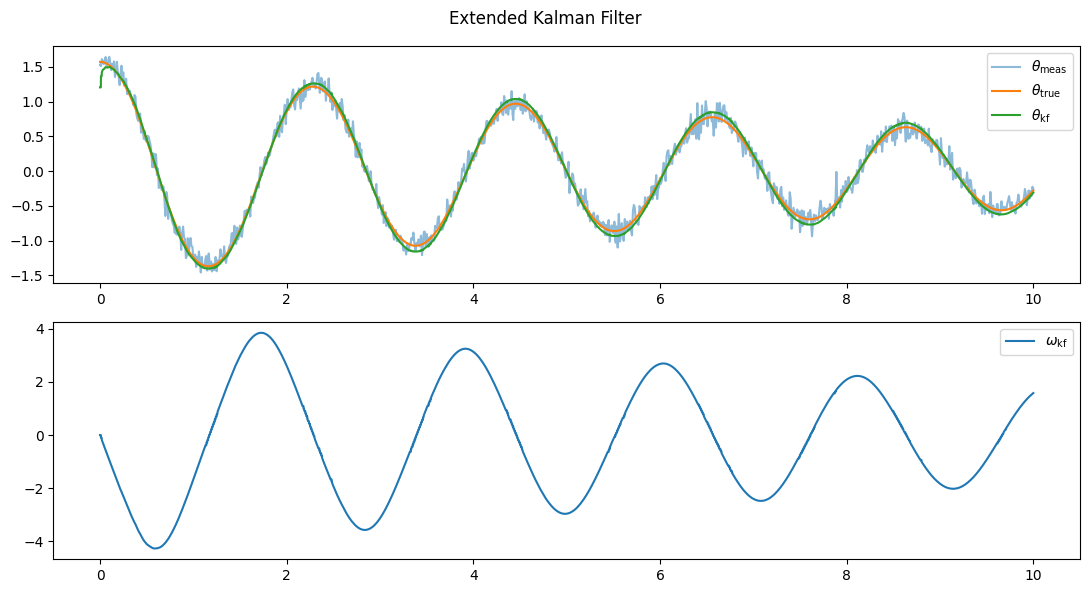

In [14]:
config = {"m": 1.0, "L": 1.0, "d": 0.2, "g": 9.81}
G = jnp.array([[0.0], [1.0 / config["m"] / config["L"] ** 2]])

builder = collimator.DiagramBuilder()

pendulum = builder.add(make_pendulum_with_disturbances(x0, Q, R, config))

kf = builder.add(
    ExtendedKalmanFilter.for_continuous_plant(
        Pendulum(x0=x0, **config, name="pendulum"),
        dt,
        G_func=lambda t: G,
        Q_func=lambda t: Q,
        R_func=lambda t: R,
        x_hat_0=x_hat_0,
        P_hat_0=P_hat_0,
        discretization_method="euler",
        name="kf",
    )
)

control = builder.add(Constant(jnp.array([0.0]), name="control"))

builder.connect(control.output_ports[0], kf.input_ports[0])
builder.connect(pendulum.output_ports[0], kf.input_ports[1])
builder.connect(control.output_ports[0], pendulum.input_ports[0])

diagram = builder.build()

context = diagram.create_context()

recorded_signals = {
    "x_true": diagram["pendulum_with_disturbances"]["pendulum"].output_ports[0],
    "x_hat": kf.output_ports[0],
    "theta_measured": pendulum.output_ports[0],    
}


sol = collimator.simulate(
    diagram,
    context,
    (0.0, Tsim),
    options=options,
    recorded_signals=recorded_signals,
)

plot_sol(sol, "Extended Kalman Filter")

Despite large angles and large difference in the initial guessed value of the pendulum, the EKF is able to remarkably provide excellent estimates of both $\theta$ and $\omega$.

## Unscented Kalman Filter

The UKF uses the Unscented Transform to approximate the state distribution through a deterministic sampling approach. This method captures the true mean and covariance of the state distribution more accurately, especially in highly nonlinear systems. This approach eliminates the need for computing Jacobians, as in the EKF.

For the the same nonlinear system presented above for the EKF, the Unscented Kalman Filter recursion equations are as follows:

1. **Sigma Point Generation and Propagation**:
   - Generate a set of sigma points $\mathbf{X}_{k-1}^+$ around the current state estimate $\mathbf{\hat{x}}_{k-1|k-1}$ to capture the mean and covariance accurately.
   - Propagate each sigma point through the nonlinear state transition function $\mathbf{f}$.
\begin{align}
\mathbf{X}_k^- &= \mathbf{f}(\mathbf{X}_{k-1}^+)\\[5pt]
\end{align}

2. **Prediction**:
   - Compute the predicted state estimate and covariance from the propagated sigma points.
\begin{align}
\mathbf{\hat{x}}_{k|k-1} &= \text{Weighted mean of } \mathbf{X}_k^-\\[5pt]
\mathbf{P}_{k|k-1} &= \text{Weighted covariance of } \mathbf{X}_k^- + \mathbf{GQG}^T\\[5pt]
\end{align}

3. **Update**:
   - Propagate the sigma points through the measurement function $\mathbf{h}$.
   - Compute the predicted measurement and its covariance.
   - Compute the Kalman gain and update the state estimate and covariance.
\begin{align}
\mathbf{Y}_k &= \mathbf{h}(\mathbf{X}_k^-)\\[5pt]
\mathbf{\hat{y}}_k &= \text{Weighted mean of } \mathbf{Y}_k\\[5pt]
\mathbf{P}_{yy,k} &= \text{Weighted covariance of } \mathbf{Y}_k + \mathbf{R}\\[5pt]
\mathbf{P}_{xy,k} &= \text{Weighted cross covariance of } \mathbf{X}_k^- \text{ and } \mathbf{Y}_k\\[5pt]
\mathbf{K}_k &= \mathbf{P}_{xy,k} \mathbf{P}_{yy,k}^{-1}\\[5pt]
\mathbf{\hat{x}}_{k|k} &= \mathbf{\hat{x}}_{k|k-1} + \mathbf{K}_k(\mathbf{y}[k] - \mathbf{\hat{y}}_k)\\[5pt]
\mathbf{P}_{k|k} &= \mathbf{P}_{k|k-1} - \mathbf{K}_k \mathbf{P}_{yy,k} \mathbf{K}_k^T\\[5pt]
\end{align}

where:

- $\mathbf{\hat{x}}_{k|k-1}$ is the state estimate at time $k$ given measurements up to time $k-1$.
  
- $\mathbf{\hat{x}}_{k|k}$ is the state estimate at time $k$ given measurements up to time $k$.

- $\mathbf{P}_{k|k-1}$ is the state estimate covariance at time $k$ given measurements up to time $k-1$.
  
- $\mathbf{P}_{k|k}$ is the state estimate covariance at time $k$ given measurements up to time $k$.

- $\mathbf{K}_k$ is the Kalman gain at time $k$.

The Unscented Kalman Filter starts with an initial state estimate $\mathbf{\hat{x}}_0 = \mathbf{\hat{x}}_{0|0}$ and $\mathbf{\hat{P}}_0 = \mathbf{P}_{0|0}$, and recursively generates optimal estimates for the state using the Unscented Transform at each step.


The UKF has a similar API to EKF, through the `UnscentedKalmanFilter.for_continuous_plant` utility. This is demonstrated below.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.01, max_major_steps=10000, ode_solver_method=default, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 3 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


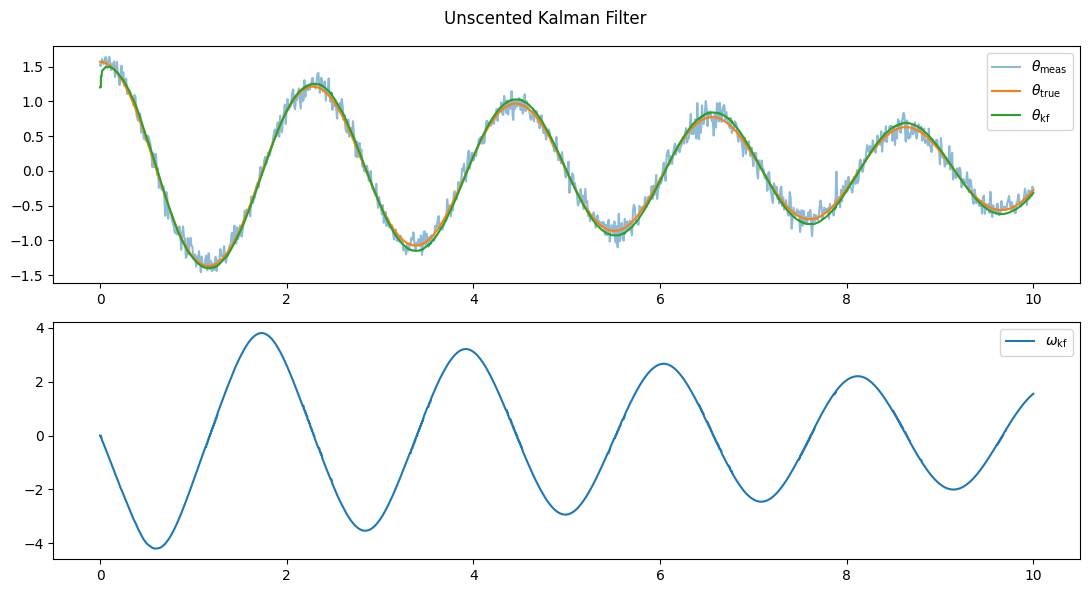

In [15]:
config = {"m": 1.0, "L": 1.0, "d": 0.2, "g": 9.81}
G = jnp.array([[0.0], [1.0 / config["m"] / config["L"] ** 2]])

builder = collimator.DiagramBuilder()

pendulum = builder.add(make_pendulum_with_disturbances(x0, Q, R, config))

kf = builder.add(
    UnscentedKalmanFilter.for_continuous_plant(
        Pendulum(x0=x0, **config, name="pendulum"),
        dt,
        G_func=lambda t: G,
        Q_func=lambda t: Q,
        R_func=lambda t: R,
        x_hat_0=x_hat_0,
        P_hat_0=P_hat_0,
        discretization_method="euler",
        name="kf",
    )
)

control = builder.add(Constant(jnp.array([0.0]), name="control"))

builder.connect(control.output_ports[0], kf.input_ports[0])
builder.connect(pendulum.output_ports[0], kf.input_ports[1])
builder.connect(control.output_ports[0], pendulum.input_ports[0])

diagram = builder.build()

context = diagram.create_context()

recorded_signals = {
    "x_true": diagram["pendulum_with_disturbances"]["pendulum"].output_ports[0],
    "x_hat": kf.output_ports[0],
    "theta_measured": pendulum.output_ports[0],
}

sol = collimator.simulate(
    diagram,
    context,
    (0.0, Tsim),
    options=options,
    recorded_signals=recorded_signals,
)

plot_sol(sol, "Unscented Kalman Filter")

Like EKF, the UKF also provides good state estimates in nonlinear regions.

For fun, we can also animate the results to visualise the UKF estimation.

In [16]:
def animate_pendulum(theta_true, theta_hat=None, theta_meas=None, length=1.0, filter_name="KF", interval=10):
    from matplotlib.animation import FuncAnimation, FFMpegWriter
    from IPython.display import HTML

    # Convert theta to Cartesian coordinates
    x = length * jnp.sin(theta_true)
    y = -length * jnp.cos(theta_true)

    xh = length * jnp.sin(theta_hat)
    yh = -length * jnp.cos(theta_hat)

    xm = length * jnp.sin(theta_meas)
    ym = -length * jnp.cos(theta_meas)

    # Create the plot with two subplots
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # First subplot for the pendulum
    (line_true,) = ax.plot([], [], "o-", lw=2, label="true")
    (line_hat,) = ax.plot([], [], "o-", lw=2, label=filter_name)
    (line_meas,) = ax.plot([], [], "o-", lw=2, alpha=0.5, label="measured")
    
    ax.set_xlim(-length - 0.5, length + 0.5)
    ax.set_ylim(-length - 0.5, length + 0.5)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Pendulum State Estimation")
    ax.legend()

    # Initialize the animation
    def init():
        line_true.set_data([], [])
        line_hat.set_data([], [])
        line_meas.set_data([], [])
        return line_true, line_hat, line_meas

    # Update function for the animation
    def update(frame):
        # Update the pendulum
        line_true.set_data([0, x[frame]], [0, y[frame]])
        line_hat.set_data([0, xh[frame]], [0, yh[frame]])
        line_meas.set_data([0, xm[frame]], [0, ym[frame]])
        return line_true, line_hat, line_meas

    # Create the animation
    ani = FuncAnimation(
        fig, update, frames=len(theta_true), init_func=init, blit=True, interval=interval
    )


    plt.close(fig)
    html_content = HTML(ani.to_html5_video())
    return html_content

In [17]:
N=300
animate_pendulum(sol.outputs["x_true"][:N], sol.outputs["x_hat"][:N, 0], sol.outputs["theta_measured"][:N, 0], filter_name="UKF", interval=50)